# Try Out The BOPTEST Building Simulator

This is a basic demo of how to use the API to send/receive requests to the server.
Based on the following Colab notebook provided in the documentation:
 - https://colab.research.google.com/github/ibpsa/project1-boptest/blob/master/docs/workshops/RlemWorkshop_20231112/Introduction_to_the_BOPTEST_framework.ipynb#scrollTo=rU_eIpcFZaVg

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Request a connection to the BOPTEST server

In [2]:
# url for the BOPTEST service
url = 'http://api.boptest.net' 

# Select test case and get identifier
testcase = 'bestest_hydronic_heat_pump'

# Check if already started a test case and stop it if so before starting another
try:
    requests.put(f'{url}/stop/{testid}')
except:
    pass

# Select and start a new test case
testid = requests.post(f'{url}/testcases/{testcase}/select').json()['testid']

### Inspect details of test case

In [3]:
name = requests.get('{0}/name/{1}'.format(url, testid)).json()['payload']
print(name)

version = requests.get('{0}/version'.format(url)).json()['payload']
print(version)

{'name': 'bestest_hydronic_heat_pump'}
{'version': '0.6.0', 'service-version': '0.4.3'}


In [4]:
available_inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()['payload']
print('Available inputs:')
print(list(available_inputs.keys()))

available_measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()['payload']
print('Available measurements:')
print(list(available_measurements.keys()))

Available inputs:
['oveFan_activate', 'oveFan_u', 'oveHeaPumY_activate', 'oveHeaPumY_u', 'ovePum_activate', 'ovePum_u', 'oveTSet_activate', 'oveTSet_u']
Available measurements:
['reaCO2RooAir_y', 'reaCOP_y', 'reaPFan_y', 'reaPHeaPum_y', 'reaPPumEmi_y', 'reaQFloHea_y', 'reaQHeaPumCon_y', 'reaQHeaPumEva_y', 'reaTRet_y', 'reaTSetCoo_y', 'reaTSetHea_y', 'reaTSup_y', 'reaTZon_y', 'weaSta_reaWeaCeiHei_y', 'weaSta_reaWeaCloTim_y', 'weaSta_reaWeaHDifHor_y', 'weaSta_reaWeaHDirNor_y', 'weaSta_reaWeaHGloHor_y', 'weaSta_reaWeaHHorIR_y', 'weaSta_reaWeaLat_y', 'weaSta_reaWeaLon_y', 'weaSta_reaWeaNOpa_y', 'weaSta_reaWeaNTot_y', 'weaSta_reaWeaPAtm_y', 'weaSta_reaWeaRelHum_y', 'weaSta_reaWeaSolAlt_y', 'weaSta_reaWeaSolDec_y', 'weaSta_reaWeaSolHouAng_y', 'weaSta_reaWeaSolTim_y', 'weaSta_reaWeaSolZen_y', 'weaSta_reaWeaTBlaSky_y', 'weaSta_reaWeaTDewPoi_y', 'weaSta_reaWeaTDryBul_y', 'weaSta_reaWeaTWetBul_y', 'weaSta_reaWeaWinDir_y', 'weaSta_reaWeaWinSpe_y']


In [5]:
inputs = ['oveHeaPumY_u']
measurements = ['reaTZon_y']

nu = len(inputs)
ny = len(measurements)

for i, input in enumerate(inputs, start=1):
    print(f"Input {i}: {input}")
    info = available_inputs[input]
    for name, value in info.items():
        print(f"  {name}: {value}")
    print()

for i, measurement in enumerate(measurements, start=1):
    print(f"Measurement {i}: {measurement}")
    info = available_measurements[measurement]
    for name, value in info.items():
        print(f"  {name}: {value}")
    print()

Input 1: oveHeaPumY_u
  Unit: 1
  Description: Heat pump modulating signal for compressor speed between 0 (not working) and 1 (working at maximum capacity)
  Minimum: 0
  Maximum: 1

Measurement 1: reaTZon_y
  Unit: K
  Description: Zone operative temperature
  Minimum: None
  Maximum: None



### Initialize simulation and run warm-up phase

In [6]:
y = requests.put(
    f'{url}/initialize/{testid}', 
    json={
        'start_time': 31 * 24 * 3600,
        'warmup_period': 7 * 24 * 3600
    }
).json()['payload']
print(y['reaTZon_y'] - 273.15)
print(y['time'] / 24 / 3600)

21.364471442540776
31.0


### Select test scenario

In [7]:
scenario_return = requests.put(
    f'{url}/scenario/{testid}', 
    json={
        'time_period': 'peak_heat_day',
        'electricity_price': 'dynamic'
    }
).json()['payload']


In [8]:
scenario = requests.get(f'{url}/scenario/{testid}').json()['payload']
scenario

{'electricity_price': 'dynamic', 'time_period': 'peak_heat_day'}

In [9]:
y = scenario_return['time_period']
pd.DataFrame([y])

,time,reaCO2RooAir_y,reaCOP_y,reaPFan_y,reaPHeaPum_y,reaPPumEmi_y,reaQFloHea_y,reaQHeaPumCon_y,reaQHeaPumEva_y,reaTRet_y,...,weaSta_reaWeaWinDir_y,weaSta_reaWeaWinSpe_y,oveFan_activate,oveFan_u,oveHeaPumY_activate,oveHeaPumY_u,ovePum_activate,ovePum_u,oveTSet_activate,oveTSet_u
0,1382400,754.158301,3.096815,510.204082,2385.272769,20.498644,7445.444857,7386.747759,-5001.47499,302.400312,...,4.537856,3.6,0,1,0,0.628307,0,1,0,294.35


In [10]:
# Record start time
start_time_days = y['time'] / 24 / 3600

## Simulation parameters

In [11]:
# Get default control step
step = requests.get(f'{url}/step/{testid}').json()['payload']
print(f'Default step period [seconds]: {step}')

# Set the control step
requests.put(f'{url}/step/{testid}', json={'step': step})
print(f'Step period [seconds]: {step}')

Default step period [seconds]: 3600
Step period [seconds]: 3600


### Advancing the Simulation

In [12]:
y = requests.post(f'{url}/advance/{testid}').json()['payload']
pd.DataFrame([y])

,time,reaCO2RooAir_y,reaCOP_y,reaPFan_y,reaPHeaPum_y,reaPPumEmi_y,reaQFloHea_y,reaQHeaPumCon_y,reaQHeaPumEva_y,reaTRet_y,...,weaSta_reaWeaWinDir_y,weaSta_reaWeaWinSpe_y,oveFan_activate,oveFan_u,oveHeaPumY_activate,oveHeaPumY_u,ovePum_activate,ovePum_u,oveTSet_activate,oveTSet_u
0,1386000,775.931175,2.987789,510.204082,2174.312092,20.498644,6604.990555,6496.386411,-4322.074319,302.178042,...,4.363323,3.1,0,1,0,0.528069,0,1,0,294.35


### Override the default controller

In [13]:
u = {
    'oveHeaPumY_u': 0.5,
    'oveHeaPumY_activate': 1
}
y = requests.post(f'{url}/advance/{testid}', json=u).json()['payload']
pd.DataFrame([y])

,time,reaCO2RooAir_y,reaCOP_y,reaPFan_y,reaPHeaPum_y,reaPPumEmi_y,reaQFloHea_y,reaQHeaPumCon_y,reaQHeaPumEva_y,reaTRet_y,...,weaSta_reaWeaWinDir_y,weaSta_reaWeaWinSpe_y,oveFan_activate,oveFan_u,oveHeaPumY_activate,oveHeaPumY_u,ovePum_activate,ovePum_u,oveTSet_activate,oveTSet_u
0,1389600,789.137202,2.959832,510.204082,2111.125574,20.498644,6318.236445,6248.577127,-4137.451553,301.858367,...,4.363323,4.1,0,1,1,0.5,0,1,0,294.35


### Inspect simulation results so far

In [14]:
args = {
    'point_names': inputs + measurements,
    'start_time': -365 * 24 * 3600, 
    'final_time': 365 * 24 *3600
}

res = requests.put(f'{url}/results/{testid}', json=args).json()['payload']
res = pd.DataFrame(res)
res.tail()

,oveHeaPumY_u,reaTZon_y,time
20396,0.5,294.565965,1389480
20397,0.5,294.565840,1389510
20398,0.5,294.565715,1389540
20399,0.5,294.565589,1389570
20400,0.5,294.565463,1389600


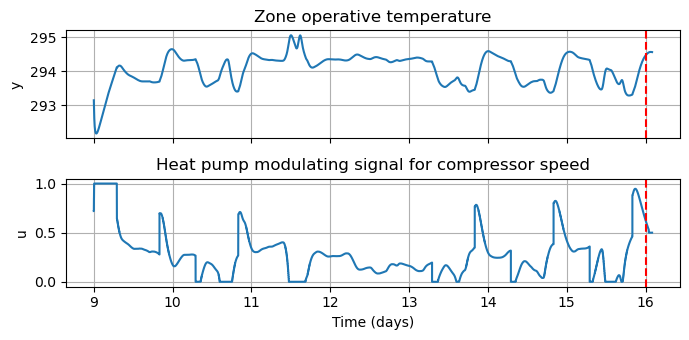

In [15]:
res['time'] = res['time'] / 24 / 3600
res = res.set_index('time')

ny = len(measurements)
nu = len(inputs)
fig, axes = plt.subplots(ny + nu, 1, sharex=True, figsize=(7, 0.5 + 1.5 * (ny + nu)))

for ax, name in zip(axes[:ny], measurements):
    res[name].plot(ax=ax, label=name)
    ax.axvline(start_time_days, linestyle='--', color='r')
    ax.set_ylabel('y')
    ax.set_title(available_measurements[name]['Description'][:48])
    ax.grid()

for ax, name in zip(axes[ny:], inputs):
    res[name].plot(ax=ax, label=name, drawstyle="steps-post")
    ax.axvline(start_time_days, linestyle='--', color='r')
    ax.set_ylabel('u')
    ax.set_title(available_inputs[name]['Description'][:48])
    ax.grid()

axes[-1].set_xlabel('Time (days)')

plt.tight_layout()
plt.show()

### KPIs

In [16]:
# Note: The warmup period is not taken into account for the calculation of the KPIs.
kpi_values = requests.get(f'{url}/kpi/{testid}').json()['payload']
kpi_values

{'tdis_tot': 0,
 'idis_tot': 0,
 'ener_tot': 0.028393274674119465,
 'cost_tot': 0.0067661173548426694,
 'emis_tot': 0.004741676870577952,
 'pele_tot': 0.015044852343014026,
 'pgas_tot': None,
 'pdih_tot': None,
 'time_rat': 3.759384155273438e-05}